In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [39]:
# Load the dataset
file_path = 'indonesian_chat.csv'
df = pd.read_csv(file_path)    
df['label'] = df['label'].astype(str)

In [50]:
def clean_chat_text(text):
    text = text.replace('\\n', ' ').replace('\n', ' ')
    sentence = re.findall(r'(\\x[0-9a-f]{2})|([a-z0-9]+)', text.lower())
    sentence_list = [item for sublist in sentence for item in sublist if item]
    return ' '.join(sentence_list)

df['chat'] = df['chat'].apply(clean_chat_text)

In [41]:
# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

X_text = df['chat'].values
y = df['label'].values
num_classes = len(np.unique(y))

In [42]:
# Tokenize texts
max_len = 128
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [43]:
# Split the data once
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42, stratify=y)

In [44]:
# Define and train GRU-based model to extract features
def build_gru_model():
    input_text = Input(shape=(max_len,), dtype=tf.int32, name='input_text')
    x = Embedding(input_dim=max_words, output_dim=128)(input_text)
    x = GRU(64, return_sequences=False, dropout=0.3)(x)
    x = Dropout(0.5)(x)
    model = Model(inputs=input_text, outputs=x)
    return model

gru_model = build_gru_model()

In [45]:
# Train GRU model using classification head temporarily
x = gru_model.output
output = Dense(num_classes, activation='softmax')(x)
temp_model = Model(inputs=gru_model.input, outputs=output)
temp_model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, min_lr=1e-6)
]

temp_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - accuracy: 0.3139 - loss: 1.3729 - val_accuracy: 0.4666 - val_loss: 1.2763 - learning_rate: 1.0000e-04
Epoch 2/10
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.5626 - loss: 1.1530 - val_accuracy: 0.6843 - val_loss: 0.8786 - learning_rate: 1.0000e-04
Epoch 3/10
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7540 - loss: 0.7236 - val_accuracy: 0.7543 - val_loss: 0.6757 - learning_rate: 1.0000e-04
Epoch 4/10
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.8466 - loss: 0.4830 - val_accuracy: 0.7847 - val_loss: 0.6010 - learning_rate: 1.0000e-04
Epoch 5/10
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.8835 - loss: 0.3578 - val_accuracy: 0.8029 - val_loss: 0.5789 - learning_rate: 1.0000e-04
Epoch 6/10
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.9128 - loss: 0.2788 - val_accuracy: 0.8071 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 7/10
1071/1071 ━━━━━━━━━━━━━━━━━━━

In [46]:
# Extract features from GRU model
feature_model = Model(inputs=gru_model.input, outputs=gru_model.output)
X_train_features = feature_model.predict(X_train)
X_val_features = feature_model.predict(X_val)

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [47]:
# Train Random Forest on extracted features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_features, y_train)

y_pred = rf.predict(X_val_features)


Evaluation Results:
  Accuracy: 0.8048
  Precision: 0.8062
  Recall: 0.8048
  F1-Score: 0.8053


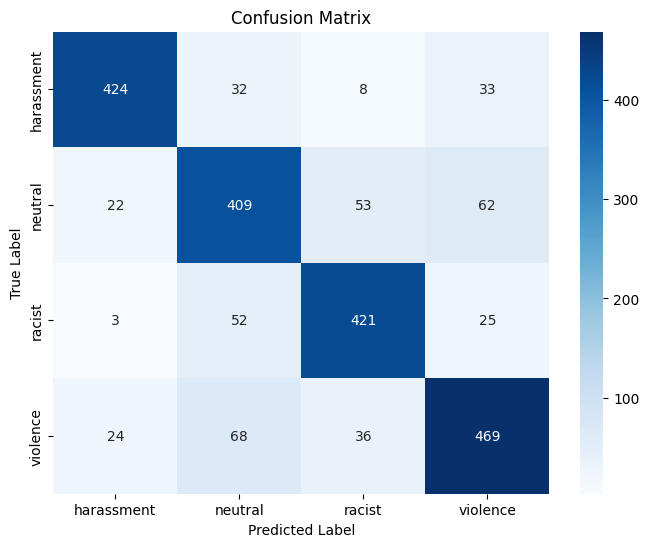

In [48]:
# Evaluation
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print("\nEvaluation Results:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()